In [10]:
import os
os.chdir(r"C:\Users\kiyj1\OneDrive - 연세대학교 (Yonsei University)\문서\YBIGTA\DA\21-1 project\data")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [12]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
train['date2'] = pd.to_datetime(train['date'])

In [17]:
train['weekday'] = train['date2'].dt.weekday

In [18]:
train = pd.get_dummies(train,columns=['weekday'])

In [19]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [20]:
del train['date2']
del test['date2']

In [21]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [22]:
train['in_out'] = train['in_out'].map({'시내':0, '시외':1})

In [24]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [25]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [26]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,weekday_3,weekday_4,weekday_5,weekday_6,68a,810a,1012a,68b,810b,1012b
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,0,0,0,1,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0,0,0,1,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0


Text(0.5, 1.0, 'arrive and leave correlation graph')

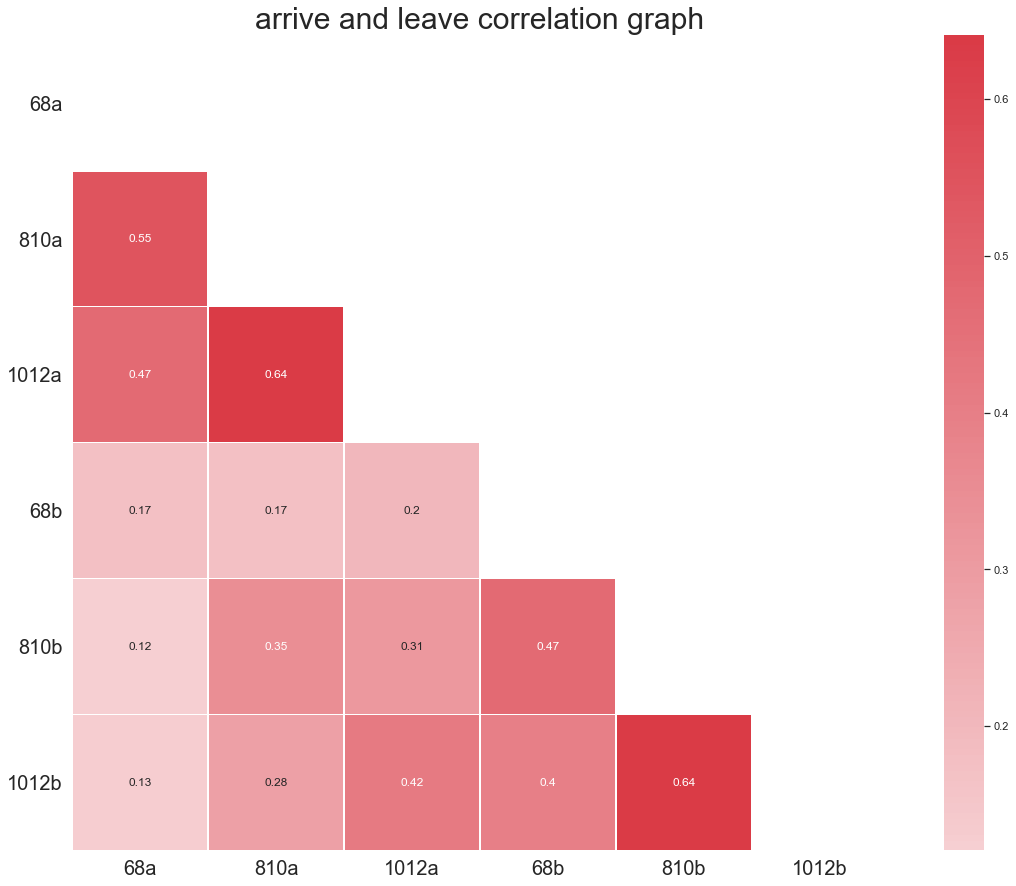

In [30]:
train22 = train[['68a', '810a', '1012a', '68b', '810b', '1012b']]

cor = train22.corr()

sns.set(style="white")
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# 히트맵 생성
sns.heatmap(cor, mask=mask, cmap = cmap, center = 0, square=True, linewidths=0.5, cbar_kws={'shrink':1}, annot = True)

plt.xticks(size = 20)
plt.yticks(size = 20, rotation= 0)
plt.title("arrive and leave correlation graph", size = 30)

In [31]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [32]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [33]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

같은 정류장의 이름이 있는게 2개가 있는 경우, 위도 경도의 평균을 적용한 다음

시각화를 하여서 해당 정류소들의 위치를 확인한 결과는 다음과 같다.

# 4-2. 측정소와 정류장 사이 거리 계산 적용
2 개의 좌표 간의 거리를 구하는 함수는 파이썬의 geopy 패키지에 존재한다.

geopy.distance.vincenty를 이용하여, m 단위 혹은 km 단위로 계산이 가능하다.(현재 baseline은 km 단위 사용)

dis_jeju : 버스정류장과 제주 측정소와의 거리

dis_gosan : 버스정류장과 고산 측정소시와의 거리

dis_seongsan : 버스정류장과 성산 측정소와의 거리

dis_po : 버스정류장과 서귀포 측정소와의 거리

각 정류장과 제주도에 존재하는 4군데의 기상 측정소와의 거리를 계산하여 t1~t4에 할당

In [36]:
import geopy

t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [37]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 3: 828, 1: 659, 2: 597})

In [39]:
t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [63]:
raining = pd.read_csv('C:/Users/kiyj1/OneDrive - 연세대학교 (Yonsei University)/문서/YBIGTA/DA/21-1 project/data/제주_날씨.csv')

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,jeju,제주,2019-09-01 00:00,23.7,NaN,NaN,NaN,2.0,180,67,1014.0,1016.4,NaN,NaN
1,jeju,제주,2019-09-01 01:00,23.7,NaN,NaN,NaN,2.1,180,67,1013.8,1016.2,NaN,NaN
2,jeju,제주,2019-09-01 02:00,23.5,NaN,NaN,NaN,1.4,180,70,1013.7,1016.1,NaN,NaN
3,jeju,제주,2019-09-01 03:00,23.4,NaN,NaN,NaN,1.1,180,68,1013.8,1016.2,NaN,NaN
4,jeju,제주,2019-09-01 04:00,23.4,NaN,NaN,NaN,1.6,180,69,1013.6,1016.0,NaN,NaN


In [64]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [65]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [72]:
rain3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dist_name  1 non-null      object 
 1   date       1 non-null      object 
 2   기온(°C)     1 non-null      float64
 3   강수량(mm)    1 non-null      float64
dtypes: float64(2), object(2)
memory usage: 160.0+ bytes


In [77]:
train = train.astype({'dist_name':'object'})

print(train.dtypes)

id                 int64
date              object
bus_route_id       int64
in_out             int64
station_code       int64
station_name      object
latitude         float64
longitude        float64
6~7_ride         float64
7~8_ride         float64
8~9_ride         float64
9~10_ride        float64
10~11_ride       float64
11~12_ride       float64
6~7_takeoff      float64
7~8_takeoff      float64
8~9_takeoff      float64
9~10_takeoff     float64
10~11_takeoff    float64
11~12_takeoff    float64
18~20_ride       float64
weekday_0          uint8
weekday_1          uint8
weekday_2          uint8
weekday_3          uint8
weekday_4          uint8
weekday_5          uint8
weekday_6          uint8
68a              float64
810a             float64
1012a            float64
68b              float64
810b             float64
1012b            float64
dis_jeju         float64
dis_gosan        float64
dis_seongsan     float64
dis_po           float64
dist_name         object
dtype: object


In [79]:
test = test.astype({'dist_name':'object'})


In [80]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [81]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

((415423, 44), (228170, 43), (415423, 39), (228170, 38))